In [2]:
import pandas as pd

DATA_PATH = "../Data/processed/biomedical_preprocessed.csv"
chunksize = 100000  # number of rows per chunk

chunk_list = []

for chunk in pd.read_csv(DATA_PATH, chunksize=chunksize):
    # Optional: filter only needed columns
    chunk = chunk[['subject_id','activity','time','a_x','a_y','a_z','pleth_1','pleth_2','pleth_3']]
    chunk_list.append(chunk)

combined_df = pd.concat(chunk_list, ignore_index=True)
print("Loaded combined_df shape:", combined_df.shape)



ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [2]:
# ===================================
# Cell 2: Sampling & Window Parameters
# ===================================

FS = 500              # Sampling frequency (Hz)
WINDOW_SEC = 5        # Window length in seconds
WINDOW_SIZE = FS * WINDOW_SEC
STEP_SIZE = WINDOW_SIZE // 2   # 50% overlap

print("Sampling frequency:", FS)
print("Window size (samples):", WINDOW_SIZE)
print("Step size (samples):", STEP_SIZE)


Sampling frequency: 500
Window size (samples): 2500
Step size (samples): 1250


In [3]:
# ===================================
# Cell 3: PPG Feature Helper Functions
# ===================================

def rms(signal):
    return np.sqrt(np.mean(signal**2))

def spectral_energy(signal):
    fft_vals = np.abs(np.fft.rfft(signal))
    return np.sum(fft_vals**2) / len(fft_vals)

def spectral_entropy(signal):
    fft_vals = np.abs(np.fft.rfft(signal))
    psd = fft_vals**2
    psd_norm = psd / np.sum(psd)
    return entropy(psd_norm)


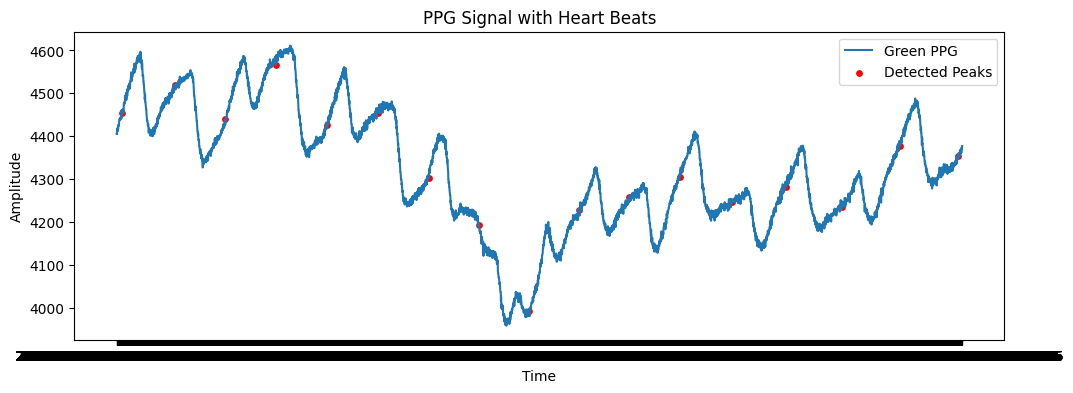

In [4]:
# ===================================
# Cell 4: PGG SIGNAL BEFORE FILTERING
# ===================================

sample = combined_df[
    (combined_df["subject_id"] == combined_df["subject_id"].iloc[0]) &
    (combined_df["activity"] == combined_df["activity"].iloc[0])
].iloc[:5000]

time = sample["time"].values
ppg = sample["pleth_3"].values
peaks = sample["peaks"].values

plt.figure(figsize=(12,4))
plt.plot(time, ppg, label="Green PPG")
plt.scatter(
    time[peaks == 1],
    ppg[peaks == 1],
    color="red",
    s=15,
    label="Detected Peaks"
)

plt.title("PPG Signal with Heart Beats")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

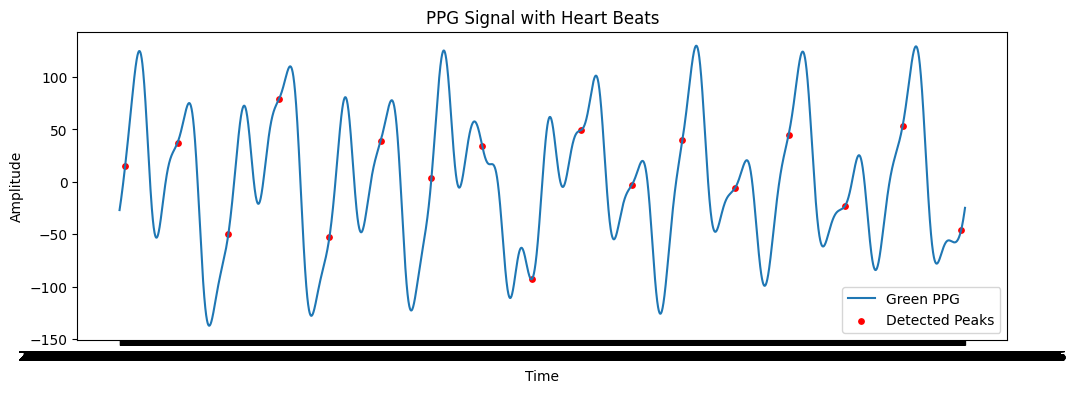

In [12]:
# ===================================
# Cell 4: PPG SIGNAL AFTER FILTERING
# ===================================

sample = combined_df[
    (combined_df["subject_id"] == combined_df["subject_id"].iloc[0]) &
    (combined_df["activity"] == combined_df["activity"].iloc[0])
].iloc[:5000]

time = sample["time"].values
ppg = sample["pleth_3_filt"].values
peaks = sample["peaks"].values

plt.figure(figsize=(12,4))
plt.plot(time, ppg, label="Green PPG")
plt.scatter(
    time[peaks == 1],
    ppg[peaks == 1],
    color="red",
    s=15,
    label="Detected Peaks"
)

plt.title("PPG Signal with Heart Beats")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [6]:
# ==========================================
# Cell 5: Heart Rate & HRV Feature Extraction (FIXED)
# ==========================================

ppg_features = []

for (subject, activity), group in combined_df.groupby(["subject_id", "activity"]):

    group = group.sort_values("time")

    ppg = group["pleth_3_filt"].values          # Green PPG
    peaks = group["peaks"].values          # Peak annotations

    for start in range(0, len(ppg) - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE

        ppg_w = ppg[start:end]
        peaks_w = peaks[start:end]

        peak_indices = np.where(peaks_w == 1)[0]

        if len(peak_indices) < 2:
            continue  # not enough beats

        # Inter-beat intervals (seconds)
        ibi = np.diff(peak_indices) / FS

        hr = 60 / np.mean(ibi)        # BPM
        hrv = np.std(ibi)             # HR variability

        ppg_features.append({
            "subject_id": subject,
            "activity": activity,
            "hr_bpm": hr,
            "hrv": hrv,
            "peak_count": len(peak_indices)
        })

ppg_hr_df = pd.DataFrame(ppg_features)

print("HR feature dataframe shape:", ppg_hr_df.shape)
ppg_hr_df.head()


HR feature dataframe shape: (1158, 5)


,subject_id,activity,hr_bpm,hrv,peak_count
0,s12,run,99.709182,0.007644,9
1,s12,run,100.190840,0.011256,8
2,s12,run,93.541203,0.036374,8
3,s12,run,86.248203,0.019813,7
4,s12,run,85.836910,0.017000,7


In [7]:
# ==========================================
# Cell 6: SpO2-Related Feature Extraction
# ==========================================

spo2_features = []

for (subject, activity), group in combined_df.groupby(["subject_id", "activity"]):

    group = group.sort_values("time")

    red = group["pleth_1_filt"].values
    ir = group["pleth_2_filt"].values

    for start in range(0, len(red) - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE

        red_w = red[start:end]
        ir_w = ir[start:end]

        # AC & DC components
        red_dc = np.mean(red_w)
        ir_dc = np.mean(ir_w)

        red_ac = np.std(red_w)
        ir_ac = np.std(ir_w)

        if red_dc == 0 or ir_dc == 0:
            continue

        R = (red_ac / red_dc) / (ir_ac / ir_dc)

        spo2_features.append({
            "subject_id": subject,
            "activity": activity,
            "R_ratio": R,
            "red_ac": red_ac,
            "ir_ac": ir_ac
        })

ppg_spo2_df = pd.DataFrame(spo2_features)

print("SpO2-related feature shape:", ppg_spo2_df.shape)
ppg_spo2_df.head()


SpO2-related feature shape: (1158, 5)


,subject_id,activity,R_ratio,red_ac,ir_ac
0,s12,run,1.580212,98.586438,256.296416
1,s12,run,1.036670,91.672293,219.962447
2,s12,run,1.550534,93.461807,202.217577
3,s12,run,1.098686,85.358685,185.129674
4,s12,run,-0.962195,73.637724,182.366085


In [8]:
# ==========================================
# Cell 7: PPG Morphological & Spectral Features
# ==========================================

morph_features = []

for (subject, activity), group in combined_df.groupby(["subject_id", "activity"]):

    group = group.sort_values("time")
    ppg = group["pleth_3_filt"].values

    for start in range(0, len(ppg) - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE

        ppg_w = ppg[start:end]

        morph_features.append({
            "subject_id": subject,
            "activity": activity,
            "ppg_mean": np.mean(ppg_w),
            "ppg_std": np.std(ppg_w),
            "ppg_rms": rms(ppg_w),
            "ppg_energy": spectral_energy(ppg_w),
            "ppg_entropy": spectral_entropy(ppg_w)
        })

ppg_morph_df = pd.DataFrame(morph_features)

print("PPG morphology feature shape:", ppg_morph_df.shape)
ppg_morph_df.head()


PPG morphology feature shape: (1158, 7)


,subject_id,activity,ppg_mean,ppg_std,ppg_rms,ppg_energy,ppg_entropy
0,s12,run,-1.116858,68.371286,68.380407,1.168347e+07,1.845303
1,s12,run,2.855715,59.774673,59.842850,8.966132e+06,2.225075
2,s12,run,2.343746,59.500541,59.546683,8.871155e+06,1.778282
3,s12,run,-2.086325,58.417425,58.454669,8.546416e+06,1.426971
4,s12,run,-0.376455,58.327658,58.328873,8.499200e+06,1.274032


In [9]:
# ==========================================
# Cell 8: Merge All PPG Features (Memory-Efficient)
# ==========================================

# Make sure all dataframes have the same length
min_len = min(len(ppg_hr_df), len(ppg_spo2_df), len(ppg_morph_df))

# Trim to the smallest length just in case
ppg_hr_df_trim = ppg_hr_df.iloc[:min_len].reset_index(drop=True)
ppg_spo2_df_trim = ppg_spo2_df.iloc[:min_len].reset_index(drop=True)
ppg_morph_df_trim = ppg_morph_df.iloc[:min_len].reset_index(drop=True)

# Drop duplicate columns before concat
ppg_spo2_df_trim = ppg_spo2_df_trim.drop(columns=["subject_id", "activity"])
ppg_morph_df_trim = ppg_morph_df_trim.drop(columns=["subject_id", "activity"])

# Concatenate horizontally
ppg_features_final = pd.concat(
    [ppg_hr_df_trim, ppg_spo2_df_trim, ppg_morph_df_trim], axis=1
)

print("Final PPG feature shape:", ppg_features_final.shape)
ppg_features_final.head()


Final PPG feature shape: (1158, 13)


,subject_id,activity,hr_bpm,hrv,peak_count,R_ratio,red_ac,ir_ac,ppg_mean,ppg_std,ppg_rms,ppg_energy,ppg_entropy
0,s12,run,99.709182,0.007644,9,1.580212,98.586438,256.296416,-1.116858,68.371286,68.380407,1.168347e+07,1.845303
1,s12,run,100.190840,0.011256,8,1.036670,91.672293,219.962447,2.855715,59.774673,59.842850,8.966132e+06,2.225075
2,s12,run,93.541203,0.036374,8,1.550534,93.461807,202.217577,2.343746,59.500541,59.546683,8.871155e+06,1.778282
3,s12,run,86.248203,0.019813,7,1.098686,85.358685,185.129674,-2.086325,58.417425,58.454669,8.546416e+06,1.426971
4,s12,run,85.836910,0.017000,7,-0.962195,73.637724,182.366085,-0.376455,58.327658,58.328873,8.499200e+06,1.274032


In [11]:
# ==========================================
# Cell 9: Save PPG Feature Dataset
# ==========================================

OUTPUT_PATH = "../Data/processed/ppg_features.csv"
ppg_features_final.to_csv(OUTPUT_PATH, index=False)

print("PPG features saved successfully.")


PPG features saved successfully.
